In [7]:
import os, io
from google.cloud import vision
from google.cloud.vision_v1 import types
import pandas as pd
import numpy as np
import cv2
from datetime import datetime, timedelta

In [8]:
#fixes 02-->oz
import re
def fix_amount(amount):
    pattern = r'(\d+)(\d{2})$'
    match = re.match(pattern, amount)
    if match:
        return match.group(1) + ' oz'
    else:
        return amount

def fix_amounts_in_text(text):
    words = text.split()
    fixed_words = [fix_amount(word) for word in words]
    fixed_text = ' '.join(fixed_words)
    return fixed_text

def add_comma_before_amounts(text):
    # Regular expression pattern to match amounts
    pattern = r'(?<!,)\b(\d+(\.\d+)?\s*(oz|tbsp|cup|g|kg))\b'   
    # Add a comma before each amount, except the first one if it's at the beginning of the sentence
    updated_text = re.sub(pattern, lambda match: ', ' + match.group(1) if match.start() > 0 else match.group(1), text)   
    return updated_text

In [9]:
os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = r'CloudVision.json' #use your own json file for CloudVision
client = vision.ImageAnnotatorClient()

In [12]:
FOLDER_PATH = r'...\OCR extraction' #set the directory
IMAGE_FILE = 'sample.png'
FILE_PATH = os.path.join(FOLDER_PATH, IMAGE_FILE)

In [16]:
# import module
from pdf2image import convert_from_path

# Store Pdf with convert_from_path function
images = convert_from_path('WW1430_Condition 2_Food Log\WW1430_Condition 2_Food Log.pdf')
 
for m in range(0,12):
    if (m!=0):
        
        # Save pages as images in the pdf
        images[m].save('WW1430_Condition 2_Food Log\page'+ str(m) +'.png', 'PNG')

        Date = []
        meal_type = ['Breakfast', 'Lunch', 'Dinner', 'Snacks', 'Snacks', 'Snacks']
        Time = []
        Foods = []
        Left = []
        Comment = []

        image = cv2.imread('WW1430_Condition 2_Food Log\page'+ str(m) +'.png')
        result = image.copy()
        gray = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
        thresh = cv2.threshold(gray, 0, 55, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]
        
        k = 120
        # Detect horizontal lines
        horizontal_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (k,1))
        detect_horizontal = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, horizontal_kernel, iterations=1)
        hcnts = cv2.findContours(detect_horizontal, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        hcnts = hcnts[0] if len(hcnts) == 2 else hcnts[1]

        # Detect vertical lines
        vertical_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1,50))
        detect_vertical = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, vertical_kernel, iterations=2)
        vcnts = cv2.findContours(detect_vertical, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        vcnts = vcnts[0] if len(vcnts) == 2 else vcnts[1]

        #filter the horizontal contours
        hlines = []
        threshold = 0
        for i in range (len(hcnts)-1, -1, -1):
            if (hcnts[i][1][0][1] > threshold + 10):
                hlines.append(hcnts[i][1][0][1])
                threshold = hcnts[i][1][0][1]
        h_coordinates = np.array(hlines)

        #filter the horizontal contours
        vlines = []
        threshold = 0
        f_vlines = []
        for i in range (len(vcnts)-1, -1, -1):
            vlines.append(vcnts[i][1][0][0])
        filtered_vlines = np.array(sorted(vlines))
        for i in range (0, filtered_vlines.shape[0]):
            if (filtered_vlines[i]-threshold > 15):
                f_vlines.append(filtered_vlines[i])
                threshold = filtered_vlines[i]
        v_coordinates = np.array(f_vlines)

        if (m == 1 or m == 8):
            for i in range (0, h_coordinates.shape[0]-1):
                for j in range (0, v_coordinates.shape[0]-1):
                    if (i== 0 or i==1):
                        break
                    # Set the ROI:
                    x = v_coordinates[j]
                    y = h_coordinates[i]
                    cropHeight = h_coordinates[i+1] - h_coordinates[i]
                    if (i == 2):
                        cropWidth = 1000
                        # Crop the ROI:
                        currentCrop = image[y:y + cropHeight, 200:300 + cropWidth]
                    else:
                        cropWidth = v_coordinates[j+1] - v_coordinates[j]

                        # Crop the ROI:
                        currentCrop = image[y:y + cropHeight, x:x + cropWidth]

                    # Saving the image
                    filename = 'savedImage.png'
                    cv2.imwrite(filename, currentCrop)

                    #extract using Google API
                    content = io.open(os.path.join(FOLDER_PATH, 'savedImage.png'), 'rb').read()
                    img = vision.Image(content=content)
                    image_context = vision.ImageContext(language_hints=['en'])
                    response = client.document_text_detection(image=img)
                    docText = response.full_text_annotation.text
                    print(docText)

                    if (i == 2):
                        Date.append(":".join(docText.split("\n")))
                    if ((i > 3) & (j == 1)):
                        Time.append(" ".join(docText.split("\n")))
                    if ((i > 3) & (j == 2)):
                        Foods.append(" ".join(docText.split("\n")))
                    if ((i > 3) & (j == 3)):
                        Left.append(" ".join(docText.split("\n")))
                    if ((i > 3) & (j == 4)):
                        Comment.append(" ".join(docText.split("\n")))

                    #view the cropped-image
                    #if (m==8):
                    #cv2.imshow("Current Crop", currentCrop)
                    #cv2.waitKey(0)
                    if (i == 0 or i == 2):
                        break    
            
        else:
            for i in range (0, h_coordinates.shape[0]-1):
                for j in range (0, v_coordinates.shape[0]-1):
                    # Set the ROI:
                    x = v_coordinates[j]
                    y = h_coordinates[i]
                    cropHeight = h_coordinates[i+1] - h_coordinates[i]
                    if (i == 0):
                        cropWidth = image.shape[0]
                    else:
                        cropWidth = v_coordinates[j+1] - v_coordinates[j]

                    # Crop the ROI:
                    currentCrop = image[y:y + cropHeight, x:x + cropWidth]

                    # Saving the image
                    filename = 'savedImage.png'
                    cv2.imwrite(filename, currentCrop)

                    #no need to extract first column

                    #extract using Google API
                    content = io.open(os.path.join(FOLDER_PATH, 'savedImage.png'), 'rb').read()
                    img = vision.Image(content=content)
                    image_context = vision.ImageContext(language_hints=['en'])
                    response = client.document_text_detection(image=img)
                    docText = response.full_text_annotation.text
                    print(docText)

                    if (i == 0):
                        Date.append(" ".join(docText.split("\n")))
                    if ((i > 1) & (j == 1)):
                        Time.append(" ".join(docText.split("\n")))
                    if ((i > 1) & (j == 2)):
                        Foods.append(" ".join(docText.split("\n")))
                    if ((i > 1) & (j == 3)):
                        Left.append(" ".join(docText.split("\n")))
                    if ((i > 1) & (j == 4)):
                        Comment.append(" ".join(docText.split("\n")))

                    #view the cropped-image
                    #if (m==1):
                    #cv2.imshow("Current Crop", currentCrop)
                    #cv2.waitKey(0)
                    if (i == 0):
                        break
            

        Experiment_D = 'Day ' + str(m)

        if (m==1):  
            if (len(np.array(Date)[0][6:]) == 8 or 7 or 10):
                updated_date = np.array(Date)[0][6:6+len(np.array(Date)[0][6:])-4] + np.array(Date)[0][6+len(np.array(Date)[0][6:])-4:] # np.array(Date)[0][6:6+len(np.array(Date)[0][6:])-2] + '20' + np.array(Date)[0][6+len(np.array(Date)[0][6:])-2:]
                print (updated_date)
                date_format = "%m/%d/%Y"
                date = datetime.strptime(updated_date, date_format)
                
        else:
            date = date + timedelta(days=1)
            print (date)
            

        print(np.array(meal_type).shape[0])
        print(np.array(Time).shape[0])
        print(np.array(Foods).shape[0])
        print(np.array(Left).shape[0])
        print(np.array(Comment).shape[0])
        d = {'Day #': Experiment_D, 'Date': date, 'Meal type': meal_type, 'Time':  Time, 'Foods, amounts, preparation': Foods, 'How much of the food/drink was lftover?': Left, 'Comments':  Comment}
        df = pd.DataFrame(d)
        df['Day'] = df['Date'].dt.day_name()
        new_cols = ["Day #","Date","Day","Meal type", "Time", "Foods, amounts, preparation", 'How much of the food/drink was lftover?', 'Comments']
        df=df[new_cols]
        
        df.to_excel('WW1430_excels/' + Experiment_D + '.xlsx')
   

Date: 3/27/2023
Meal Type
Time
Foods, amounts, preparation
How much of the food/drink
was leftover?
Comments
Breakfast
5:00 al
am
3 cups
" - 1202 instant Coffee, Sprokle sugo,
3-zubale milk
поне
2802 wate
between
breakfast & lunch
Lunch
11:20
Panera
1/2 turkey Sandwich
Freit Cup
Sm broc mas & cheese
испе

Dinner
mdis
Potstickers with white rice, greenbeaus
peppers, broccoli,
Soy Sauce
carrots,
поле
finishal
kids 'bouls they
barely touched
one of my

Morning:
nove


Snacks
Afternoon:
2:30pm
2cups of nachos, 28ozwater
1
Scratch Culinary Herb Grilled Chicken meal
поле


Evening:
11:00pm
Pot stickers with white rice, groabeans, carrots,
Denpers, broccoli soy sauce
иси
filaushed other two kids'
Oartial dinner bowls
داس
3/27/2023
6
6
6
6
6
Day 2
Date: 3/28/2023
Meal Type
Time
Foods, amounts, preparation
How much of the food/drink
was leftover?
Comments
Breakfast
6:00am
Rozwiate
2 cups 12oz instant coffee sprinkle sugar,
1202
i
302 whole milk
попе

Lunch
15 ар
изто
2802 water
Danda Express
me

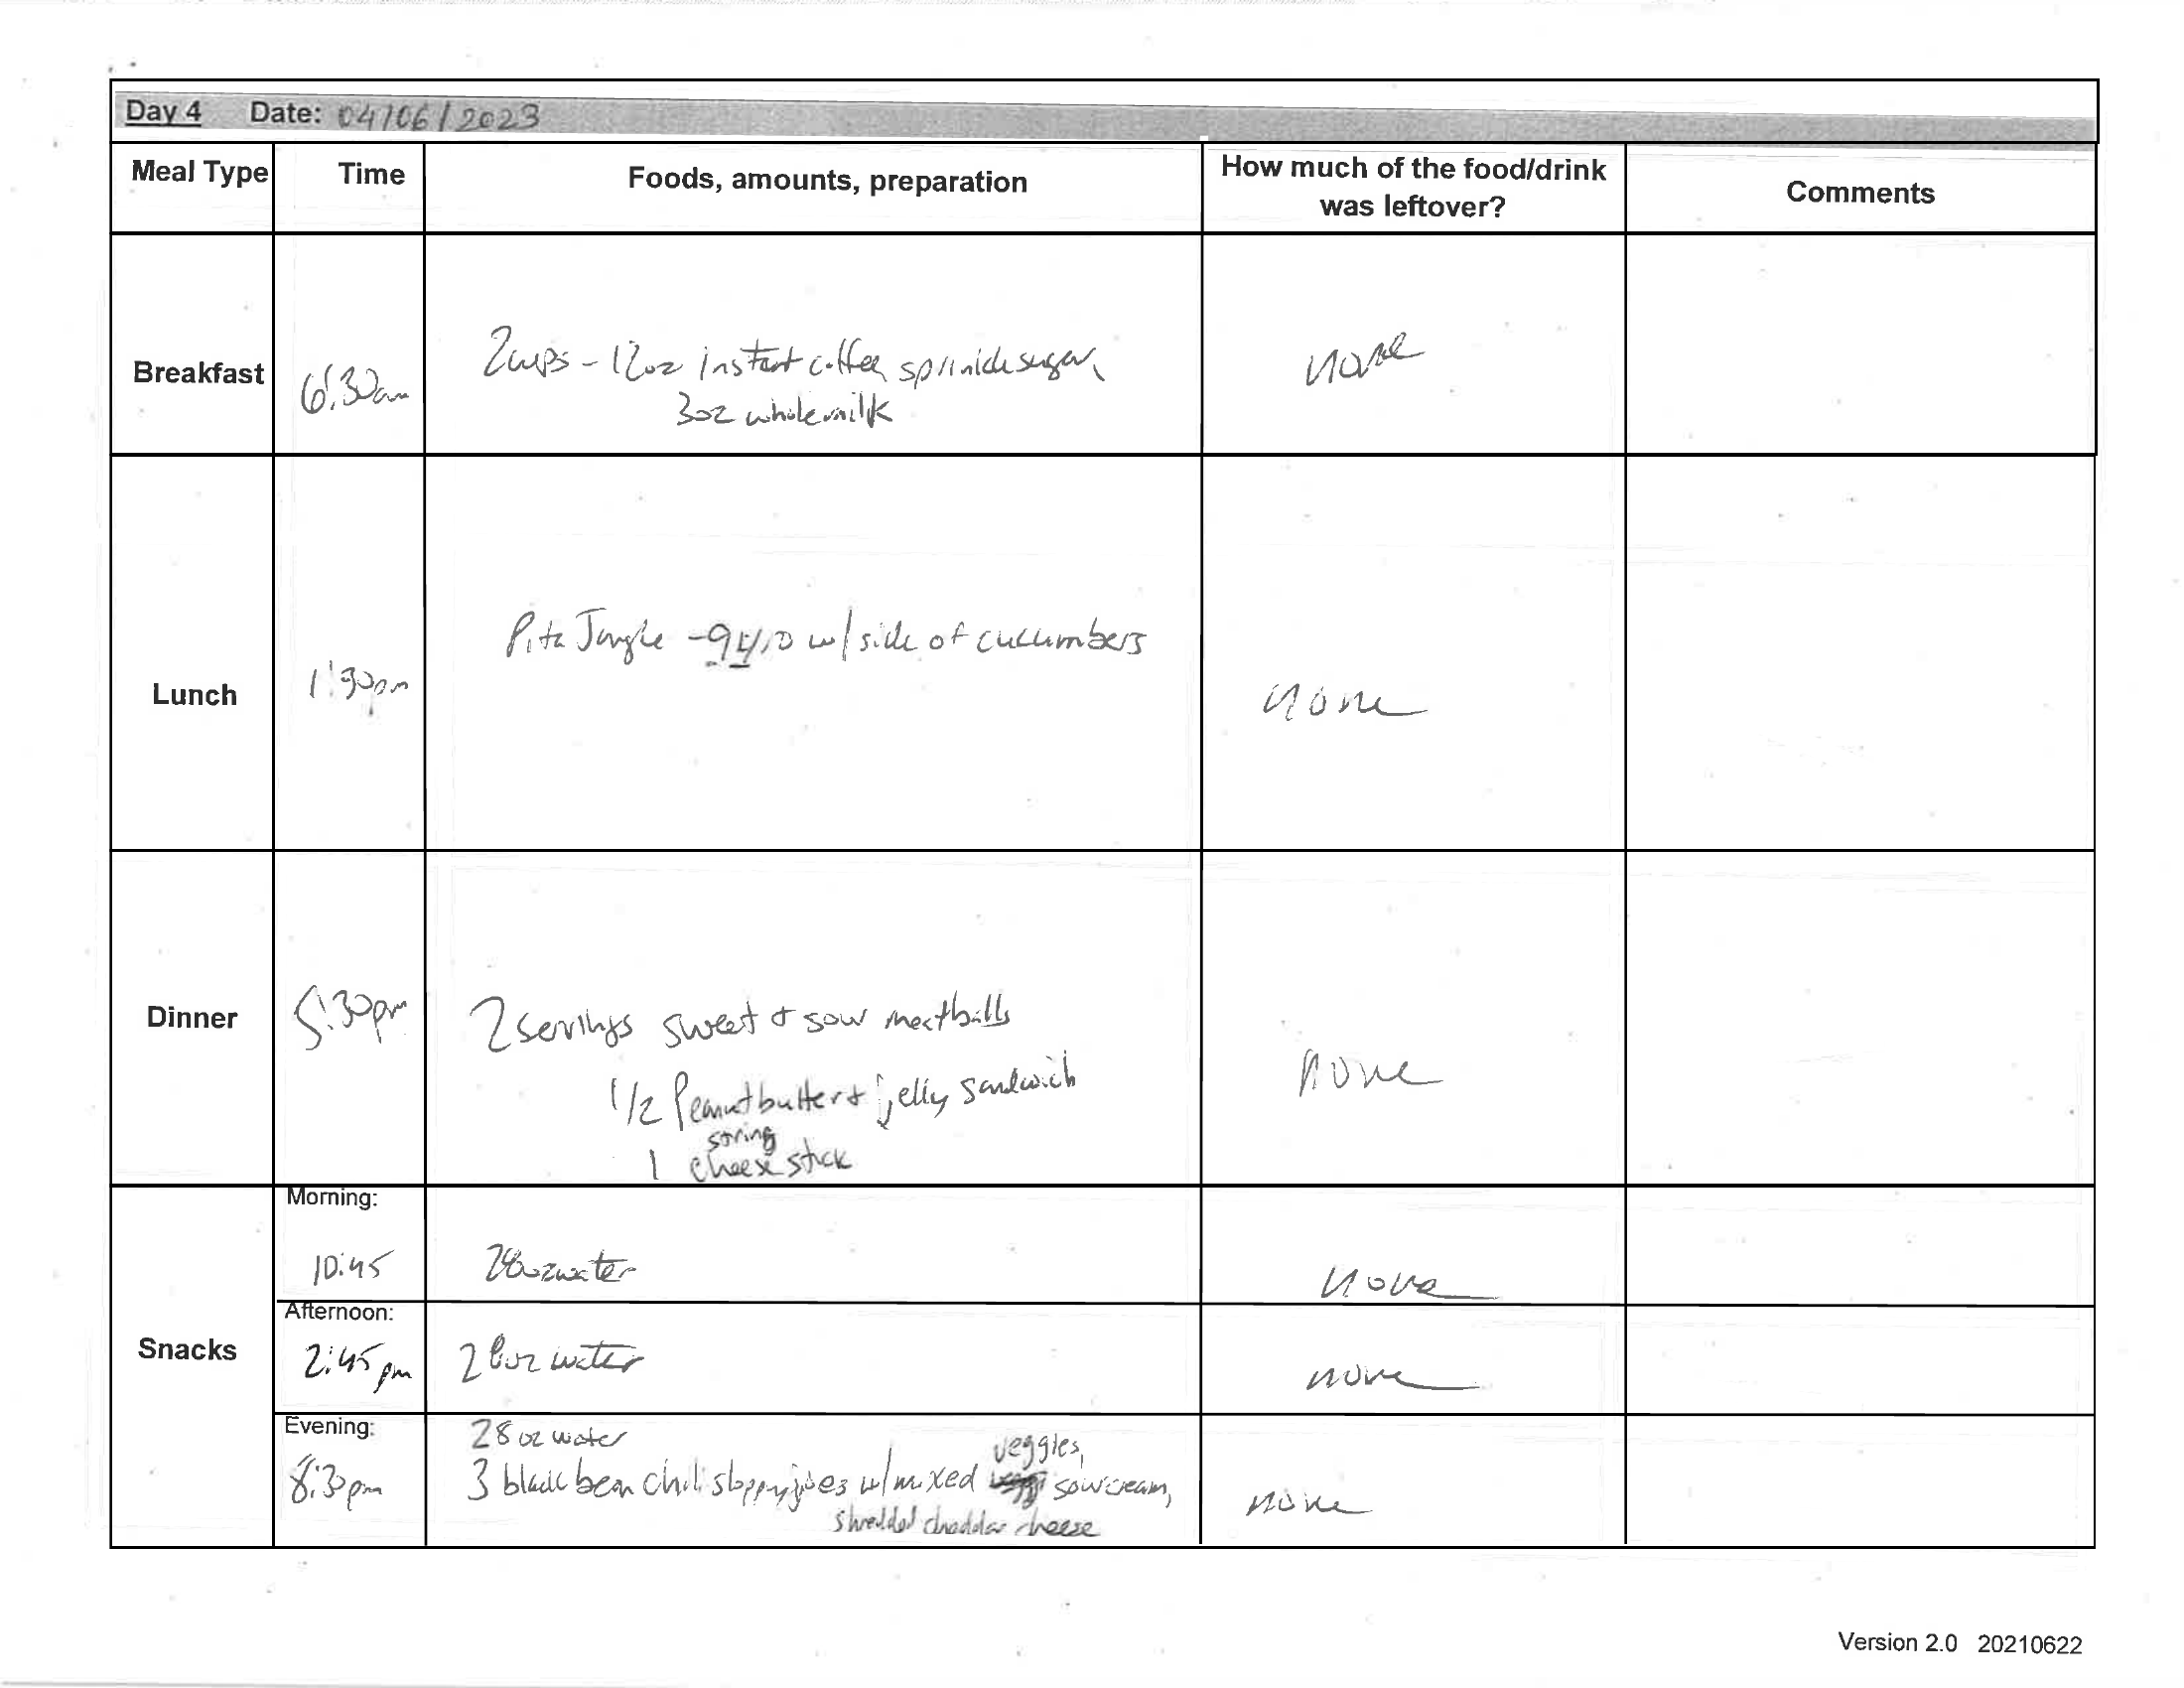

In [20]:
images[11]

In [17]:
df

,Day #,Date,Day,Meal type,Time,"Foods, amounts, preparation",How much of the food/drink was lftover?,Comments
0,Day 11,2023-04-06,Thursday,Breakfast,6.30см,Zcups - 12oz instart coffee spriniche sugar 30...,nove,
1,Day 11,2023-04-06,Thursday,Lunch,1:300m,Pitz Jangle -94/10 w/ side of cucumbers,пом,
2,Day 11,2023-04-06,Thursday,Dinner,det S,Z serings sweet & sow meatballs 1/2 Peanut but...,поне,
3,Day 11,2023-04-06,Thursday,Snacks,Morning: 10:45,Vozwater,поне,
4,Day 11,2023-04-06,Thursday,Snacks,Afternoon: 2:45 ри,2 bur water,سلمان را,
5,Day 11,2023-04-06,Thursday,Snacks,Evening: 63 ра,2802 water veggies 3 blacic bean chili sloppyp...,nove,
